In [1]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import torchtoolbox.transform as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
import pandas as pd
import numpy as np
import gc
import os
import cv2
import time
import datetime
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
from efficientnet_pytorch import EfficientNet
%matplotlib inline

In [2]:
warnings.simplefilter('ignore')
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(47)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
device

device(type='cpu')

In [45]:
train_df = pd.read_csv('/Users/gsingh/Documents/Personnal/Projects/MelanomaClassification/data/raw/train/train_subset.csv')
test_df = pd.read_csv('/Users/gsingh/Documents/Personnal/Projects/MelanomaClassification/data/raw/test/test_subset.csv')





In [46]:
train_df['target'].unique()

array([0, 1])

In [47]:
train_df[train_df['target']==1]

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
1,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,1
3,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,1
5,ISIC_0074311,IP_2950485,female,40.0,lower extremity,unknown,benign,1


In [48]:
concat = pd.concat([train_df['anatom_site_general_challenge'], test_df['anatom_site_general_challenge']], ignore_index=True)
dummies = pd.get_dummies(concat, dummy_na=True, dtype=np.uint8, prefix='site')
train_df = pd.concat([train_df, dummies.iloc[:train_df.shape[0]]], axis=1)
test_df = pd.concat([test_df, dummies.iloc[train_df.shape[0]:].reset_index(drop=True)], axis=1)

# Sex features
train_df['sex'] = train_df['sex'].map({'male': 1, 'female': 0})
test_df['sex'] = test_df['sex'].map({'male': 1, 'female': 0})
train_df['sex'] = train_df['sex'].fillna(-1)
test_df['sex'] = test_df['sex'].fillna(-1)

# Age features
train_df['age_approx'] /= train_df['age_approx'].max()
test_df['age_approx'] /= test_df['age_approx'].max()
train_df['age_approx'] = train_df['age_approx'].fillna(0)
test_df['age_approx'] = test_df['age_approx'].fillna(0)

train_df['patient_id'] = train_df['patient_id'].fillna(0)
meta_features = ['sex', 'age_approx'] + [col for col in train_df.columns if 'site_' in col]
meta_features.remove('anatom_site_general_challenge')

In [49]:
meta_features

['sex',
 'age_approx',
 'site_head/neck',
 'site_lower extremity',
 'site_torso',
 'site_upper extremity',
 'site_nan']

In [10]:
class AdvancedHairAugmentation:
    """
    Impose an image of a hair to the target image

    Args:
        hairs (int): maximum number of hairs to impose
        hairs_folder (str): path to the folder with hairs images
    """

    def __init__(self, hairs: int = 5, hairs_folder: str = ""):
        self.hairs = hairs
        self.hairs_folder = hairs_folder

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to draw hairs on.

        Returns:
            PIL Image: Image with drawn hairs.
        """
        n_hairs = random.randint(0, self.hairs)
        
        if not n_hairs:
            return img
        
        height, width, _ = img.shape  # target image width and height
        hair_images = [im for im in os.listdir(self.hairs_folder) if 'png' in im]
        
        for _ in range(n_hairs):
            hair = cv2.imread(os.path.join(self.hairs_folder, random.choice(hair_images)))
            hair = cv2.flip(hair, random.choice([-1, 0, 1]))
            hair = cv2.rotate(hair, random.choice([0, 1, 2]))

            h_height, h_width, _ = hair.shape  # hair image width and height
            roi_ho = random.randint(0, img.shape[0] - hair.shape[0])
            roi_wo = random.randint(0, img.shape[1] - hair.shape[1])
            roi = img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width]

            # Creating a mask and inverse mask
            img2gray = cv2.cvtColor(hair, cv2.COLOR_BGR2GRAY)
            ret, mask = cv2.threshold(img2gray, 10, 255, cv2.THRESH_BINARY)
            mask_inv = cv2.bitwise_not(mask)

            # Now black-out the area of hair in ROI
            img_bg = cv2.bitwise_and(roi, roi, mask=mask_inv)

            # Take only region of hair from hair image.
            hair_fg = cv2.bitwise_and(hair, hair, mask=mask)

            # Put hair in ROI and modify the target image
            dst = cv2.add(img_bg, hair_fg)

            img[roi_ho:roi_ho + h_height, roi_wo:roi_wo + h_width] = dst
                
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(hairs={self.hairs}, hairs_folder="{self.hairs_folder}")'

In [11]:
class Microscope:
    """
    Cutting out the edges around the center circle of the image
    Imitating a picture, taken through the microscope

    Args:
        p (float): probability of applying an augmentation
    """

    def __init__(self, p: float = 0.5):
        self.p = p

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to apply transformation to.

        Returns:
            PIL Image: Image with transformation.
        """
        if random.random() < self.p:
            circle = cv2.circle((np.ones(img.shape) * 255).astype(np.uint8), # image placeholder
                        (img.shape[0]//2, img.shape[1]//2), # center point of circle
                        random.randint(img.shape[0]//2 - 3, img.shape[0]//2 + 15), # radius
                        (0, 0, 0), # color
                        -1)

            mask = circle - 255
            img = np.multiply(img, mask)
        
        return img

    def __repr__(self):
        return f'{self.__class__.__name__}(p={self.p})'

In [12]:
class Net(nn.Module):
    def __init__(self, arch, n_meta_features: int):
        super(Net, self).__init__()
        self.arch = arch
        if 'ResNet' in str(arch.__class__):
            self.arch.fc = nn.Linear(in_features=512, out_features=500, bias=True)
        if 'EfficientNet' in str(arch.__class__):
            self.arch._fc = nn.Linear(in_features=1280, out_features=500, bias=True)
        self.meta = nn.Sequential(nn.Linear(n_meta_features, 500),
                                  nn.BatchNorm1d(500),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2),
                                  nn.Linear(500, 250),  # FC layer output will have 250 features
                                  nn.BatchNorm1d(250),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.2))
        self.ouput = nn.Linear(500 + 250, 1)
        
    def forward(self, inputs):
        """
        No sigmoid in forward because we are going to use BCEWithLogitsLoss
        Which applies sigmoid for us when calculating a loss
        """
        x, meta = inputs
        cnn_features = self.arch(x)
        meta_features = self.meta(meta)
        features = torch.cat((cnn_features, meta_features), dim=1)
        output = self.ouput(features)
        return output

In [ ]:
class MelanomaDataset(Dataset):
    def __init__(self, df: pd.DataFrame, imfolder: str, train: bool = True, transforms = None, meta_features = None):
        """
        Class initialization
        Args:
            df (pd.DataFrame): DataFrame with data description
            imfolder (str): folder with images
            train (bool): flag of whether a training dataset is being initialized or testing one
            transforms: image transformation method to be applied
            meta_features (list): list of features with meta information, such as sex and age
            
        """
        self.df = df
        self.imfolder = imfolder
        self.transforms = transforms
        self.train = train
        self.meta_features = meta_features
        
    def __getitem__(self, index):
        im_path = os.path.join(self.imfolder, self.df.iloc[index]['image_name'] + '.jpg')
        print(im_path)
        x = cv2.imread(im_path)
#         print("self.df.iloc[index][self.meta_features].values = ",self.df.iloc[index, self.meta_features].values)
        meta = np.array(self.df.loc[index, self.meta_features].values, dtype=np.float32)

        if self.transforms:
            x = self.transforms(x)
            
        if self.train:
            y = self.df.iloc[index]['target']
            return (x, meta), y
        else:
            return (x, meta)
    
    def __len__(self):
        return len(self.df)

In [50]:
test_df.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,site_head/neck,site_lower extremity,site_torso,site_upper extremity,site_nan
0,ISIC_0052060,IP_3579794,1,1.000000,NaN,0,0,0,0,1
1,ISIC_0052349,IP_7782715,1,0.571429,lower extremity,0,1,0,0,0
2,ISIC_0058510,IP_7960270,0,0.785714,torso,0,0,1,0,0
3,ISIC_0073313,IP_6375035,0,0.714286,torso,0,0,1,0,0
4,ISIC_0074618,IP_4438996,1,0.714286,lower extremity,0,1,0,0,0


In [51]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    AdvancedHairAugmentation(hairs_folder='/Users/gsingh/Documents/Personnal/Projects/MelanomaClassification/data/external/Hairs/'),
    transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    Microscope(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
    transforms.Resize((256, 256))
])

train = MelanomaDataset(df=train_df.reset_index(drop=True), 
                        imfolder='/Users/gsingh/Documents/Personnal/Projects/MelanomaClassification/data/raw/train/images', 
                        train=True, 
                        transforms=train_transform,
                        meta_features=meta_features)

test = MelanomaDataset(df=test_df,
                       imfolder='/Users/gsingh/Documents/Personnal/Projects/MelanomaClassification/data/raw/test/images', 
                       train=False,
                       transforms=train_transform,  # For TTA
                       meta_features=meta_features)



train_loader = DataLoader(dataset=train, batch_size=64, shuffle=True, num_workers=2)


In [15]:
from torchvision import utils

index =  3
index =  0
index =  2
index =  6
index =  4
index =  1
index =  5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


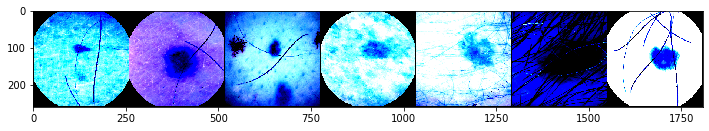

In [16]:
for i, sampled_batch in enumerate(train_loader):
    (x, meta), y = sampled_batch
    x = x
    grid = utils.make_grid(x, nrow=1)
    plt.figure(figsize=(12,10))
    plt.imshow(grid.numpy().transpose((2, 1, 0)))


In [18]:
arch = EfficientNet.from_pretrained('efficientnet-b1')

Loaded pretrained weights for efficientnet-b1


In [19]:
arch

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=

In [57]:
epochs = 1  # Number of epochs to run

es_patience = 3  # Early Stopping patience - for how many epochs with no improvements to wait
TTA = 3 # Test Time Augmentation rounds

oof = np.zeros((len(train_df), 1))  # Out Of Fold predictions
preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)  # Predictions for test test

skf = KFold(n_splits=2, shuffle=True, random_state=47)

In [58]:
for fold, (train_idx, val_idx) in enumerate(skf.split(X=np.zeros(len(train_df)), y=train_df['target'], groups=train_df['patient_id'].tolist()), 1):
    print("val size = ", len(val_idx))
    print("train size = ", len(train_idx))
    print('=' * 20, 'Fold', fold, '=' * 20)  
    
    model_path = f'model_{fold}.pth'  # Path and filename to save model to
    best_val = 0  # Best validation score within this fold
    patience = es_patience  # Current patience counter
    arch = EfficientNet.from_pretrained('efficientnet-b1')
    model = Net(arch=arch, n_meta_features=len(meta_features))  # New model for each fold
    model = model.to(device)
    
    optim = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer=optim, mode='max', patience=1, verbose=True, factor=0.2)
    criterion = nn.BCEWithLogitsLoss()
    
    train = MelanomaDataset(df=train_df.iloc[train_idx].reset_index(drop=True), 
                            imfolder='/Users/gsingh/Documents/Personnal/Projects/MelanomaClassification/data/raw/train/images', 
                            train=True, 
                            transforms=train_transform,
                            meta_features=meta_features)
    val = MelanomaDataset(df=train_df.iloc[val_idx].reset_index(drop=True), 
                            imfolder='/Users/gsingh/Documents/Personnal/Projects/MelanomaClassification/data/raw/train/images', 
                            train=True, 
                            transforms=train_transform,
                            meta_features=meta_features)
    
    train_loader = DataLoader(dataset=train, batch_size=64, shuffle=True, num_workers=0)
    val_loader = DataLoader(dataset=val, batch_size=16, shuffle=False, num_workers=0)
    test_loader = DataLoader(dataset=test, batch_size=16, shuffle=False, num_workers=0)
    
    for epoch in range(epochs):
        start_time = time.time()
        correct = 0
        epoch_loss = 0
        model.train()
        
        for kk, (x, y) in enumerate(train_loader):
            x[0] = torch.tensor(x[0], device=device, dtype=torch.float32)
            x[1] = torch.tensor(x[1], device=device, dtype=torch.float32)
            y = torch.tensor(y, device=device, dtype=torch.float32)
            optim.zero_grad()
            z = model(x)
            loss = criterion(z, y.unsqueeze(1))
            loss.backward()
            optim.step()
            pred = torch.round(torch.sigmoid(z))  # round off sigmoid to obtain predictions
            correct += (pred.cpu() == y.cpu().unsqueeze(1)).sum().item()  # tracking number of correctly predicted samples
            epoch_loss += loss.item()
        train_acc = correct / len(train_idx)
    
        model.eval()  # switch model to the evaluation mode
        val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
        with torch.no_grad():  # Do not calculate gradient since we are only predicting
            # Predicting on validation set
            for j, (x_val, y_val) in enumerate(val_loader):
                x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
                x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
                y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
                z_val = model(x_val)
                val_pred = torch.sigmoid(z_val)
                val_preds[j*val_loader.batch_size:j*val_loader.batch_size + x_val[0].shape[0]] = val_pred
            val_acc = accuracy_score(train_df.iloc[val_idx]['target'].values, torch.round(val_preds.cpu()))
            val_roc = roc_auc_score(train_df.iloc[val_idx]['target'].values, val_preds.cpu())
            
            print('Epoch {:03}: | Loss: {:.3f} | Train acc: {:.3f} | Val acc: {:.3f} | Val roc_auc: {:.3f} | Training time: {}'.format(
            epoch + 1, 
            epoch_loss, 
            train_acc, 
            val_acc, 
            val_roc, 
            str(datetime.timedelta(seconds=time.time() - start_time))[:7]))
            
            scheduler.step(val_roc)
                
            if val_roc >= best_val:
                best_val = val_roc
                patience = es_patience  # Resetting patience since we have new best validation accuracy
                torch.save(model, model_path)  # Saving current best model
            else:
                patience -= 1
                if patience == 0:
                    print('Early stopping. Best Val roc_auc: {:.3f}'.format(best_val))
                    break
                
    model = torch.load(model_path)  # Loading best model of this fold
    model.eval()  # switch model to the evaluation mode
    val_preds = torch.zeros((len(val_idx), 1), dtype=torch.float32, device=device)
    with torch.no_grad():
        # Predicting on validation set once again to obtain data for OOF
        for j, (x_val, y_val) in enumerate(val_loader):
            x_val[0] = torch.tensor(x_val[0], device=device, dtype=torch.float32)
            x_val[1] = torch.tensor(x_val[1], device=device, dtype=torch.float32)
            y_val = torch.tensor(y_val, device=device, dtype=torch.float32)
            z_val = model(x_val)
            val_pred = torch.sigmoid(z_val)
            val_preds[j*val_loader.batch_size:j*val_loader.batch_size + x_val[0].shape[0]] = val_pred
        oof[val_idx] = val_preds.cpu().numpy()
        
        # Predicting on test set
        tta_preds = torch.zeros((len(test), 1), dtype=torch.float32, device=device)
        for _ in range(TTA):
            for i, x_test in enumerate(test_loader):
                print(x_test[0].shape)
                print(x_test[1].shape)
                x_test[0] = torch.tensor(x_test[0], device=device, dtype=torch.float32)
                x_test[1] = torch.tensor(x_test[1], device=device, dtype=torch.float32)
                z_test = model(x_test)
                z_test = torch.sigmoid(z_test)
                tta_preds[i*test_loader.batch_size:i*test_loader.batch_size + x_test[0].shape[0]] += z_test
        preds += tta_preds / TTA
    
preds /= skf.n_splits

val size =  4
train size =  3
==================== Fold 1 ====================
Loaded pretrained weights for efficientnet-b1
/Users/gsingh/Documents/Personnal/Projects/MelanomaClassification/data/raw/train/images/ISIC_0052212.jpg
(1053, 1872, 3)
index =  0
/Users/gsingh/Documents/Personnal/Projects/MelanomaClassification/data/raw/train/images/ISIC_0074268.jpg
(4000, 6000, 3)
index =  2
/Users/gsingh/Documents/Personnal/Projects/MelanomaClassification/data/raw/train/images/ISIC_0074311.jpg
(4000, 6000, 3)
index =  1
/Users/gsingh/Documents/Personnal/Projects/MelanomaClassification/data/raw/train/images/ISIC_0068279.jpg
(1053, 1872, 3)
index =  0
/Users/gsingh/Documents/Personnal/Projects/MelanomaClassification/data/raw/train/images/ISIC_0075663.jpg
(1936, 2592, 3)
index =  1
/Users/gsingh/Documents/Personnal/Projects/MelanomaClassification/data/raw/train/images/ISIC_0015719.jpg
(4000, 6000, 3)
index =  2
/Users/gsingh/Documents/Personnal/Projects/MelanomaClassification/data/raw/train/im

In [59]:
preds

tensor([[0.3929],
        [0.3675],
        [0.3766],
        [0.3689],
        [0.3911]])

In [60]:
print('OOF: {:.3f}'.format(roc_auc_score(train_df['target'], oof)))

OOF: 0.333


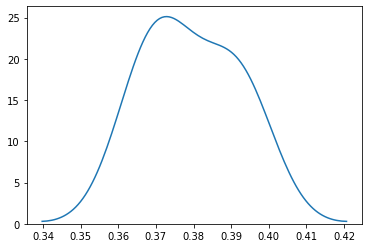

In [61]:
sns.kdeplot(pd.Series(preds.cpu().numpy().reshape(-1,)));
